In [1]:
import numpy as np

import tensorflow_datasets as tfds
import tensorflow as tf

tfds.disable_progress_bar()

In [2]:
import matplotlib.pyplot as plt


def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

In [3]:
dataset, info = tfds.load('imdb_reviews', with_info=True,
                          as_supervised=True)
train_dataset, test_dataset = dataset['train'], dataset['test']

train_dataset.element_spec

Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteVVJAM2/imdb_reviews-train.tfrecord
Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteVVJAM2/imdb_reviews-test.tfrecord
Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteVVJAM2/imdb_reviews-unsupervised.tfrecord


Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

In [4]:
for example, label in train_dataset.take(1):
  print('text: ', example.numpy())
  print('label: ', label.numpy())

text:  b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it."
label:  0


In [5]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64

In [6]:
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [7]:
for example, label in train_dataset.take(1):
  print('texts: ', example.numpy()[:3])
  print()
  print('labels: ', label.numpy()[:3])

texts:  [b"This movie appears to have been made by someone with some good ideas but who also never had made a movie before nor had they considered that a script should be edited or even funny. When I saw this film, I saw it for John Candy and assumed, incorrectly, that it would be hilarious. Instead, there was a stupid plot about mind control and so many flat, unfunny moments. And, to top it off, Candy delivered some of the crudest lines I had ever heard up to that time. So, despite a potentially funny cast and story idea, we are left with an amateurish and crude movie that will probably be too stupid for the average adult, though teens will probably find a few laughs. It's really a shame--it could have been so much better. I mean, with Eugene Levy, Joe Flaherty and John Candy it SHOULD have been wonderful."
 b"What a terrible film. It sucked. It was terrible. I don't know what to say about this film but DinoCrap, which I stole from some reviewer with a nail up his ass. AHAHAHAHAHHAHAH

## Create the text encoder

In [8]:
VOCAB_SIZE = 1000
encoder = tf.keras.layers.experimental.preprocessing.TextVectorization(
    max_tokens=VOCAB_SIZE)
encoder.adapt(train_dataset.map(lambda text, label: text))

In [9]:
vocab = np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'the', 'and', 'a', 'of', 'to', 'is', 'in', 'it', 'i',
       'this', 'that', 'br', 'was', 'as', 'for', 'with', 'movie', 'but'],
      dtype='<U14')

In [10]:
encoded_example = encoder(example)[:3].numpy()
encoded_example

array([[ 11,  18, 717, ...,   0,   0,   0],
       [ 49,   4, 384, ...,   0,   0,   0],
       [147,   2,  86, ...,   0,   0,   0]])

In [11]:
for n in range(3):
  print("Original: ", example[n].numpy())
  print("Round-trip: ", " ".join(vocab[encoded_example[n]]))
  print()

Original:  b"This movie appears to have been made by someone with some good ideas but who also never had made a movie before nor had they considered that a script should be edited or even funny. When I saw this film, I saw it for John Candy and assumed, incorrectly, that it would be hilarious. Instead, there was a stupid plot about mind control and so many flat, unfunny moments. And, to top it off, Candy delivered some of the crudest lines I had ever heard up to that time. So, despite a potentially funny cast and story idea, we are left with an amateurish and crude movie that will probably be too stupid for the average adult, though teens will probably find a few laughs. It's really a shame--it could have been so much better. I mean, with Eugene Levy, Joe Flaherty and John Candy it SHOULD have been wonderful."
Round-trip:  this movie appears to have been made by someone with some good ideas but who also never had made a movie before nor had they [UNK] that a script should be [UNK] or e

In [12]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

In [13]:
print([layer.supports_masking for layer in model.layers])

[False, True, True, True, True]


In [14]:
# predict on a sample text without padding.

sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')
predictions = model.predict(np.array([sample_text]))
print(predictions[0])

[-0.01289881]


In [15]:
# predict on a sample text with padding

padding = "the " * 2000
predictions = model.predict(np.array([sample_text, padding]))
print(predictions[0])

[-0.01289881]


Compile the Keras model to configure the training process:

In [16]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

## Train the model

In [17]:
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/10
391/391 [==============================] - 107s 251ms/step - loss: 0.6294 - accuracy: 0.5795 - val_loss: 0.4605 - val_accuracy: 0.7740
Epoch 2/10
391/391 [==============================] - 95s 241ms/step - loss: 0.3841 - accuracy: 0.8255 - val_loss: 0.4003 - val_accuracy: 0.7771
Epoch 3/10
391/391 [==============================] - 93s 237ms/step - loss: 0.3363 - accuracy: 0.8503 - val_loss: 0.3364 - val_accuracy: 0.8562
Epoch 4/10
391/391 [==============================] - 92s 233ms/step - loss: 0.3185 - accuracy: 0.8624 - val_loss: 0.3372 - val_accuracy: 0.8443
Epoch 5/10
391/391 [==============================] - 92s 233ms/step - loss: 0.3126 - accuracy: 0.8650 - val_loss: 0.3521 - val_accuracy: 0.8219
Epoch 6/10
391/391 [==============================] - 91s 230ms/step - loss: 0.3086 - accuracy: 0.8690 - val_loss: 0.3240 - val_accuracy: 0.8516
Epoch 7/10
391/391 [==============================] - 91s 232ms/step - loss: 0.3062 - accuracy: 0.8670 - val_loss: 0.3306 - val_a

In [18]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

391/391 [==============================] - 47s 119ms/step - loss: 0.3208 - accuracy: 0.8613
Test Loss: 0.3207709491252899
Test Accuracy: 0.8613200187683105


(0.0, 0.646046644449234)

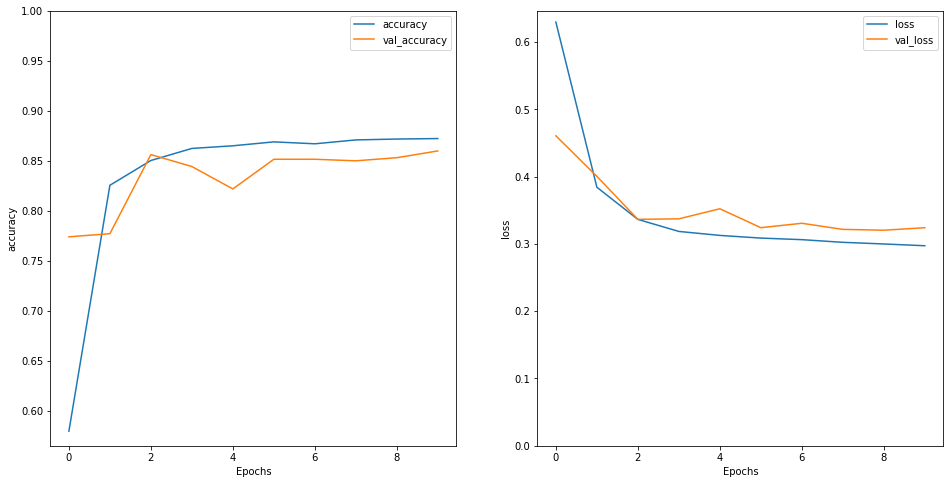

In [19]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)

In [20]:
sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')
predictions = model.predict(np.array([sample_text]))

In [21]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 64, mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1)
])

In [22]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [23]:
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/10
391/391 [==============================] - 197s 461ms/step - loss: 0.6314 - accuracy: 0.5791 - val_loss: 0.4542 - val_accuracy: 0.8078
Epoch 2/10
391/391 [==============================] - 170s 432ms/step - loss: 0.4041 - accuracy: 0.8222 - val_loss: 0.3741 - val_accuracy: 0.8417
Epoch 3/10
391/391 [==============================] - 170s 432ms/step - loss: 0.3565 - accuracy: 0.8476 - val_loss: 0.3566 - val_accuracy: 0.8328
Epoch 4/10
391/391 [==============================] - 170s 432ms/step - loss: 0.3310 - accuracy: 0.8590 - val_loss: 0.3490 - val_accuracy: 0.8380
Epoch 5/10
391/391 [==============================] - 170s 433ms/step - loss: 0.3185 - accuracy: 0.8636 - val_loss: 0.3340 - val_accuracy: 0.8557
Epoch 6/10
391/391 [==============================] - 169s 431ms/step - loss: 0.3168 - accuracy: 0.8651 - val_loss: 0.3435 - val_accuracy: 0.8604
Epoch 7/10
391/391 [==============================] - 170s 434ms/step - loss: 0.3065 - accuracy: 0.8701 - val_loss: 0.3304 -

In [24]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

391/391 [==============================] - 89s 228ms/step - loss: 0.3228 - accuracy: 0.8632
Test Loss: 0.32278135418891907
Test Accuracy: 0.8631600141525269


In [25]:
# predict on a sample text without padding.

sample_text = ('The movie was not good. The animation and the graphics '
               'were terrible. I would not recommend this movie.')
predictions = model.predict(np.array([sample_text]))
print(predictions)

[[-1.7674457]]


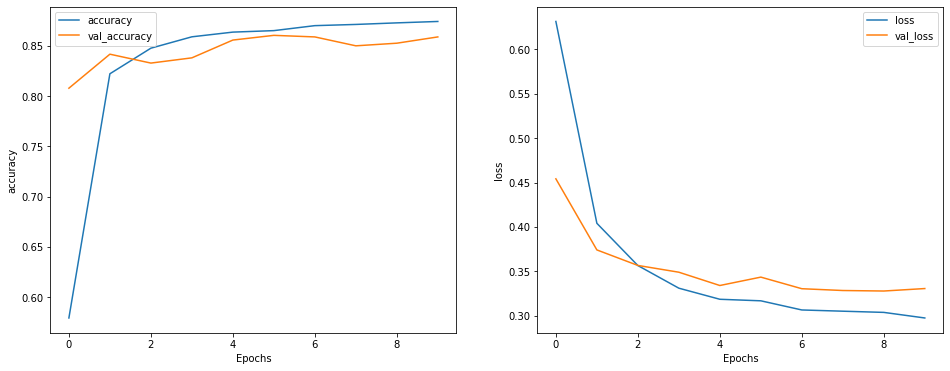

In [26]:
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')